In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread
import datetime
import os
%config Completer.use_jedi=False

In [2]:
# Parameters for the notebook 

# Amount of images to use from the data (t speed up things)
MAX_SAMPLES = 10222

# Image resolution
IMG_SIZE = 244

# Batch size
BATCH_SIZE = 8

In [3]:
# Checking if we have our GPU available
physical_devices = tf.config.list_physical_devices("GPU")
tf.__version__

'2.2.0'

In [4]:
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
labels = pd.read_csv('resources/dogs/labels.csv')
labels.count()

id       10222
breed    10222
dtype: int64

<AxesSubplot:>

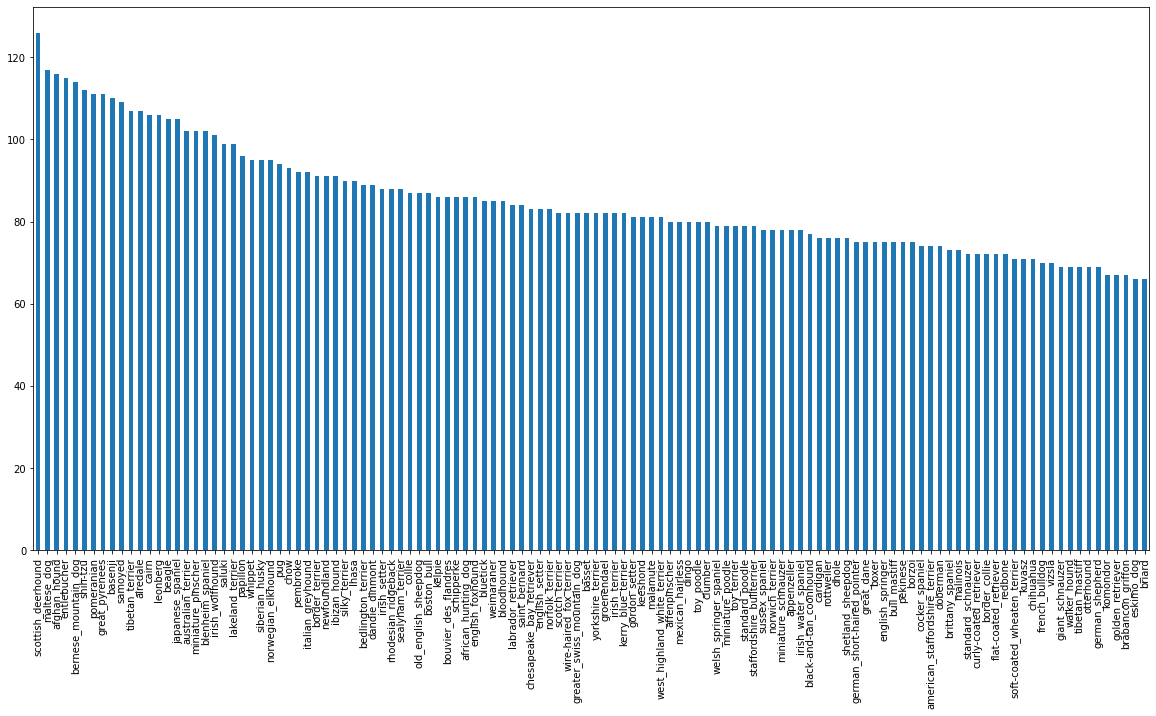

In [6]:
labels.breed.value_counts().plot(kind='bar', figsize=(20,10))

In [7]:
base_path = "resources/dogs/train/"
fmt = ".jpg"
file_names = [f"{base_path}{filename}{fmt}" for filename in labels.id]

In [8]:
# Number of labels matches the number of files (it should, of course)
len(file_names) == labels.shape[0]

True

In [9]:
breeds = labels.breed.unique()
breeds[:5]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever'],
      dtype=object)

In [10]:
# Turn the label into a boolena OHE array
labels.breed.iloc[0] == breeds

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [11]:
# Same as above for all labels, then we convert it into integers for our Model
final_labels = np.array([label == breeds for label in labels.breed])
final_labels = final_labels.astype(int)

In [12]:
# Creating our own validation set

# First we give our data proper names
x = file_names
y = final_labels

# Splitting training and validation
x_train, x_val, y_train, y_val = train_test_split(x[:MAX_SAMPLES], y[:MAX_SAMPLES], test_size=0.2)

In [13]:
"""
Read image from file and prepare it for the model
"""
def process_img(path, size = IMG_SIZE):
    # Read raw image
    image = tf.io.read_file(path)
    # Decode jpg with 3 channels (RGB)
    image = tf.image.decode_jpeg(image, channels = 3)
    # Normalize values so they are between 0-1
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize image to our specified size
    image = tf.image.resize(image, size=[size, size])
    
    return image

In [14]:
# Turning the data into batches

"""
Returns a tuple with image and label as tensors
"""
def get_image_label(path, label):
    return process_img(path), label

In [15]:
def get_data_batches(x, y=None, batch_size=BATCH_SIZE, test_data=False, valid_data=False):
    if test_data:
        print("Creating test batches...")
        # Make a dataset from the filenames
        data = tf.data.Dataset.from_tensor_slices(tf.constant(x))
        # For each image, preprocess it using our function
        data_batch = data.map(process_img).batch(batch_size)
    else:
        # Make a dataset from the filenames
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                                   tf.constant(y))) # labels
        
        if not valid_data:
            print("Creating shuffled Training bathces...")
            # shuffling data, it is faster to shuffle filenames
            data = data.shuffle(buffer_size=len(x))
        else:
            print("Creating validation batches...")
            
        # For each image, preprocess it using our function
        data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

In [16]:
train_data = get_data_batches(x_train, y_train)
val_data = get_data_batches(x_val, y_val, valid_data=True)

Creating shuffled Training bathces...
Creating validation batches...


In [17]:
# Model definitions
# Some number of 244x244 3-channel (RGB) images
INPUT = [None, IMG_SIZE, IMG_SIZE, 3]

# 120 elements vectors, one for each breed
OUTPUT = 120

# Model URL from TF HUB
MODEL_URL = "https://tfhub.dev/google/imagenet/inception_v1/classification/4"

In [18]:
def create_model(input_shape=INPUT, outputs=OUTPUT, model_url=MODEL_URL):
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url),
        tf.keras.layers.Dense(units=outputs,
                              activation="softmax")
    ])

    model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics = ['accuracy'])

    model.build(input_shape)
    
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  6633209   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 6,753,449
Trainable params: 120,240
Non-trainable params: 6,633,209
_________________________________________________________________


In [19]:
#Tensor Board Callback, wo we can see our model performance later
# Load the TensorBoard extension so we can see it inside the notebook
%load_ext tensorboard

In [20]:
# Callback to generate tensorboard logs
def create_tensorboard_callback(log_dir="resources/dogs/logs"):
    log_path = f"{log_dir}/{datetime.datetime.now().strftime('%d%m%Y-%H%M%S')}"
    
    return tf.keras.callbacks.TensorBoard(log_path)

# Callback for early stopping
def create_early_stopping_callback(**kwargs):
    return tf.keras.callbacks.EarlyStopping(**kwargs)

In [21]:
NUM_EPOCHS = 100

def train_model(model, train_data, val_data, callbacks = [], epochs=NUM_EPOCHS):
    model.fit(train_data,
              epochs=epochs,
              validation_data=val_data,
              validation_freq=1,
              callbacks=callbacks)
    return model

In [22]:
trained_model = train_model(create_model(), 
                            train_data, 
                            val_data, 
                            callbacks = [create_tensorboard_callback(), 
                                         create_early_stopping_callback(monitor='val_accuracy', patience=8)])

Epoch 1/100
1023/1023 [==============================] - 29s 28ms/step - loss: 1.3426 - accuracy: 0.6491 - val_loss: 0.9463 - val_accuracy: 0.7384
Epoch 2/100
1023/1023 [==============================] - 27s 26ms/step - loss: 0.6155 - accuracy: 0.8128 - val_loss: 1.0174 - val_accuracy: 0.7350
Epoch 3/100
1023/1023 [==============================] - 27s 26ms/step - loss: 0.4270 - accuracy: 0.8634 - val_loss: 1.1598 - val_accuracy: 0.7247
Epoch 4/100
1023/1023 [==============================] - 27s 26ms/step - loss: 0.3226 - accuracy: 0.8969 - val_loss: 1.1911 - val_accuracy: 0.7247
Epoch 5/100
1023/1023 [==============================] - 27s 26ms/step - loss: 0.2575 - accuracy: 0.9162 - val_loss: 1.3372 - val_accuracy: 0.7178
Epoch 6/100
1023/1023 [==============================] - 27s 26ms/step - loss: 0.2069 - accuracy: 0.9314 - val_loss: 1.3859 - val_accuracy: 0.7193
Epoch 7/100
1023/1023 [==============================] - 27s 26ms/step - loss: 0.1775 - accuracy: 0.9409 - val_loss: 1

In [23]:
%tensorboard --logdir 'resources/dogs/logs/' 

In [26]:
predictions = np.argmax(trained_model.predict(val_data), axis=-1)
predictions

array([115, 105,  82, ...,  16,  84,  59])